In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import warnings
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split

import time
warnings.filterwarnings("ignore")

In [82]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/xgboost/enc_data_multi.csv')
esc = pd.read_csv('../../data/regional_datasets/xgboost/esc_data_multi.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/xgboost/mid_atlantic_data_multi.csv')
mountain = pd.read_csv('../../data/regional_datasets/xgboost/mountain_data_multi.csv')
new_england = pd.read_csv('../../data/regional_datasets/xgboost/new_england_data_multi.csv')
pacific = pd.read_csv('../../data/regional_datasets/xgboost/pacific_data_multi.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/xgboost/south_atlantic_data_multi.csv')
wnc = pd.read_csv('../../data/regional_datasets/xgboost/wnc_data_multi.csv')
wsc = pd.read_csv('../../data/regional_datasets/xgboost/wsc_data_multi.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df.drop(['Unnamed: 1', 'Unnamed: 0', 'location_key.1'], axis=1, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(np.int64)
    df.set_index('date', inplace=True)


In [88]:
def train_baseline_model(df, feature_perc=0.95, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    df.sort_index(inplace=True)

    unique_days = df.index.normalize().unique()

    train_days = unique_days[:int(len(unique_days) * 0.85)]
    validation_days = unique_days[int(len(unique_days) * 0.85):int(len(unique_days) * 0.925)]
    test_days = unique_days[int(len(unique_days) * 0.925):]


    train_df = df[df.index.normalize().isin(train_days)]
    validation_df = df[df.index.normalize().isin(validation_days)]
    test_df = df[df.index.normalize().isin(test_days)]

    # train_df, temp_test_df = train_test_split(df, test_size=0.15, shuffle=False)
    # val, test  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    train = pd.concat([train_df, validation_df])
    test = test_df

    X_train = train.drop(columns=['new_confirmed', 'region', 'location_key'])
    # X_train = train[features]
    y_train = train['new_confirmed']
    # y_train_log = np.log(y_train)
    # y_train_log.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    X_test = test.drop(columns=['new_confirmed', 'region', 'location_key'])
    # X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, early_stopping_rounds=10,)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)

    # make predictions
    y_pred = model.predict(X_test)

    actual = y_test.groupby(y_test.index).sum()
    y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
    y_train_gb = y_train.groupby(y_train.index).sum()

    # calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    # mse = mean_squared_error(actual, y_pred_gb)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

    print(f'MAE: {round(mae, 2)}')
    # print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions for {region}')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(actual.index, actual, label='Actual')
        plt.plot(actual.index, y_pred_gb, label='Predicted')
        plt.legend() 
        plt.show()

     

    # stats = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
    # stats = stats.sort_values('importance', ascending=False)  
    # stats = stats.sort_values('importance', ascending=False)
    # stats["cum_importance"] = np.cumsum(stats['importance'])

    # n_percent = np.where(stats["cum_importance"] > feature_perc)[0][0] + 1

    # important_features = stats[:n_percent] 
    # print(f"Number of features for {feature_perc * 100}% importance: {n_percent}, out of {len(stats)}")
    # print(f"Important features: {list(important_features.index)}")

Training model for East North Central...
MAE: 909.91
RMSE: 1658.79
MASE: 0.39


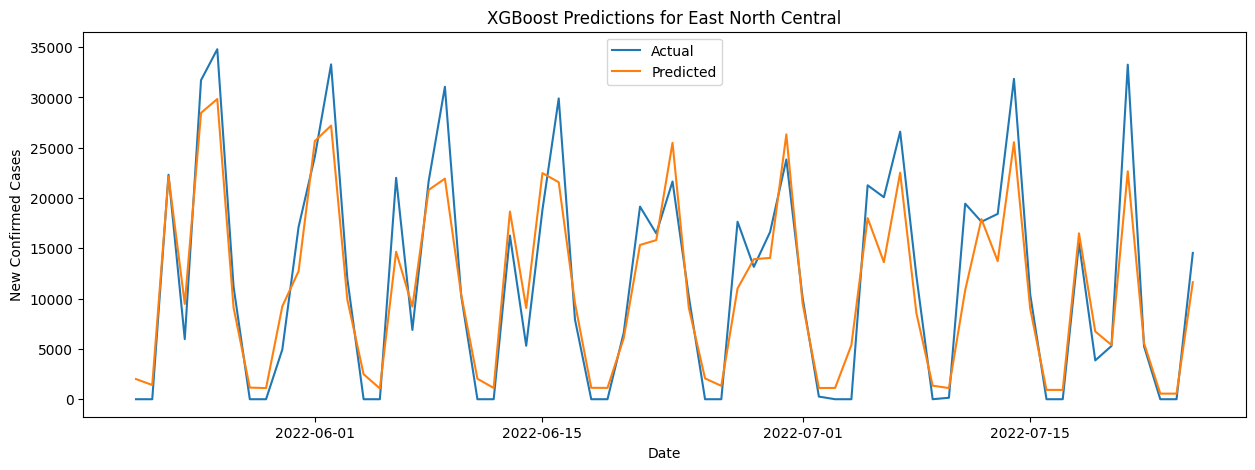



Training model for East South Central...
MAE: 693.35
RMSE: 1280.51
MASE: 0.49


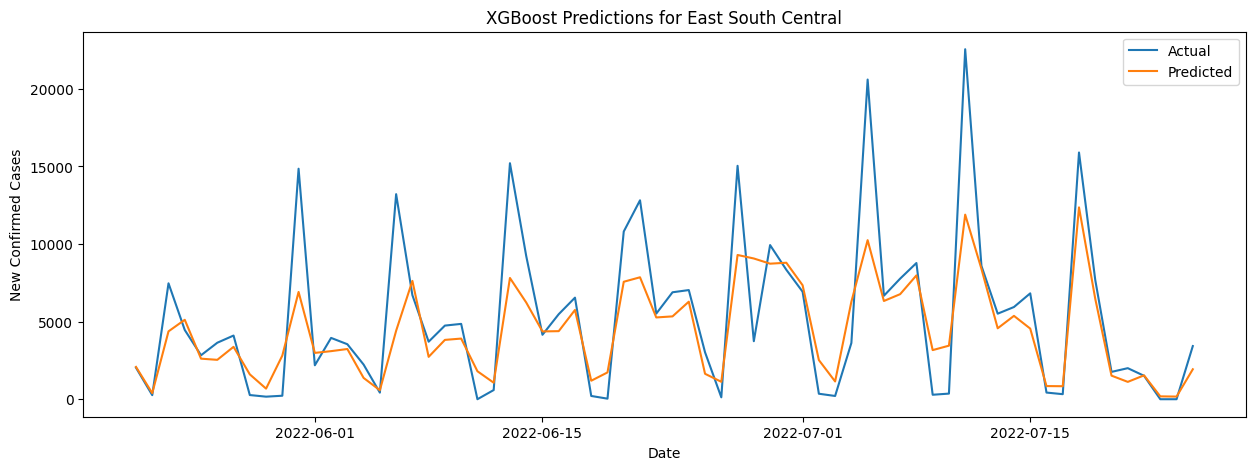



Training model for Mid-Atlantic...
MAE: 2280.28
RMSE: 3442.87
MASE: 0.84


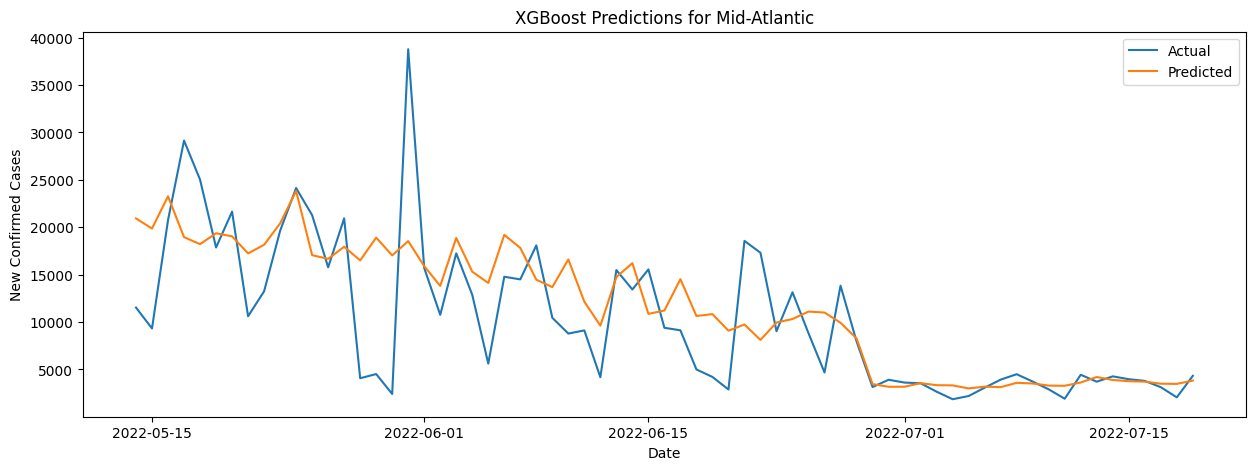



Training model for Mountain...
MAE: 601.36
RMSE: 1502.24
MASE: 0.57


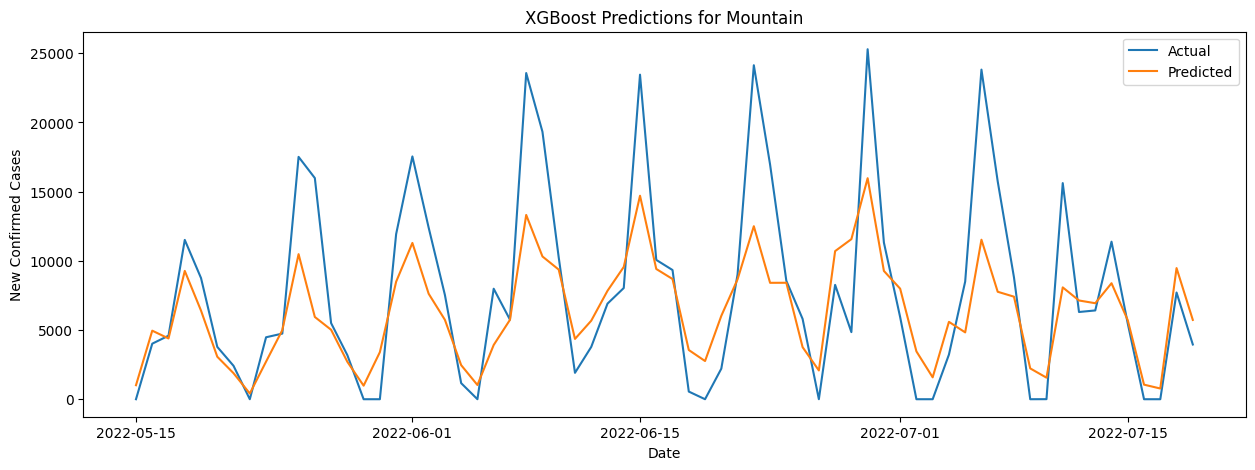



Training model for New England...
MAE: 351.15
RMSE: 637.12
MASE: 0.36


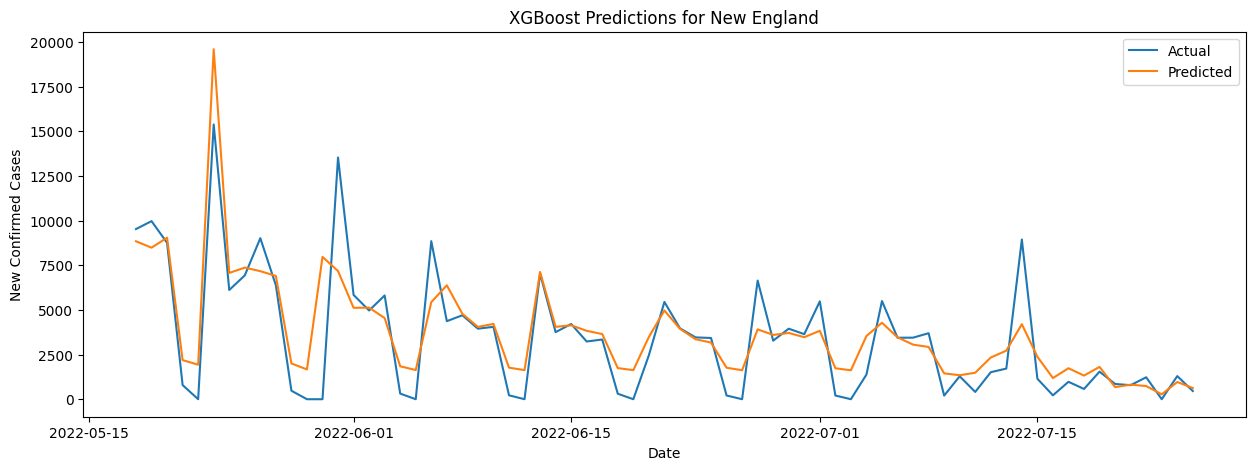



Training model for Pacific...
MAE: 3158.69
RMSE: 7916.31
MASE: 0.66


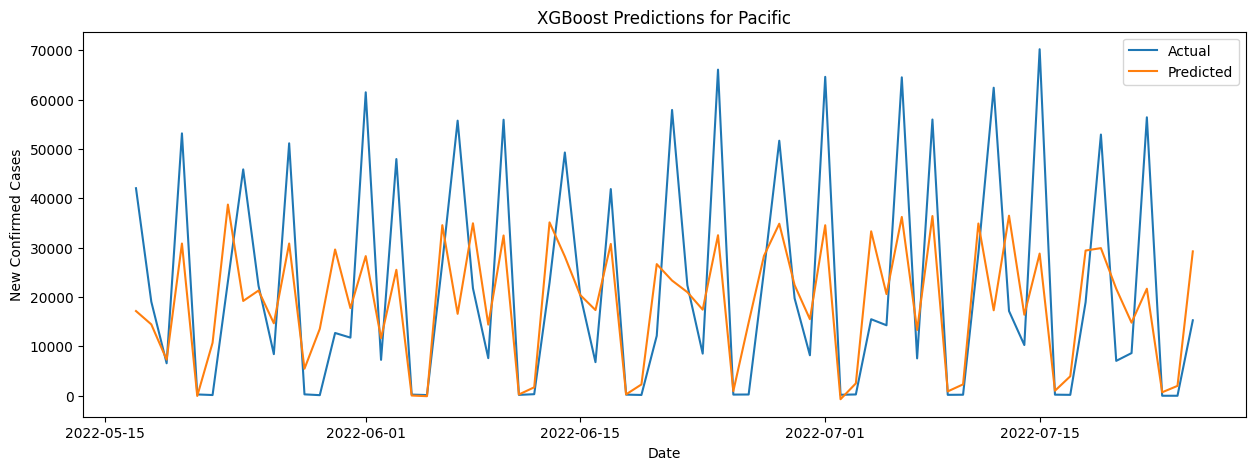



Training model for South Atlantic...
MAE: 1302.48
RMSE: 3053.93
MASE: 0.47


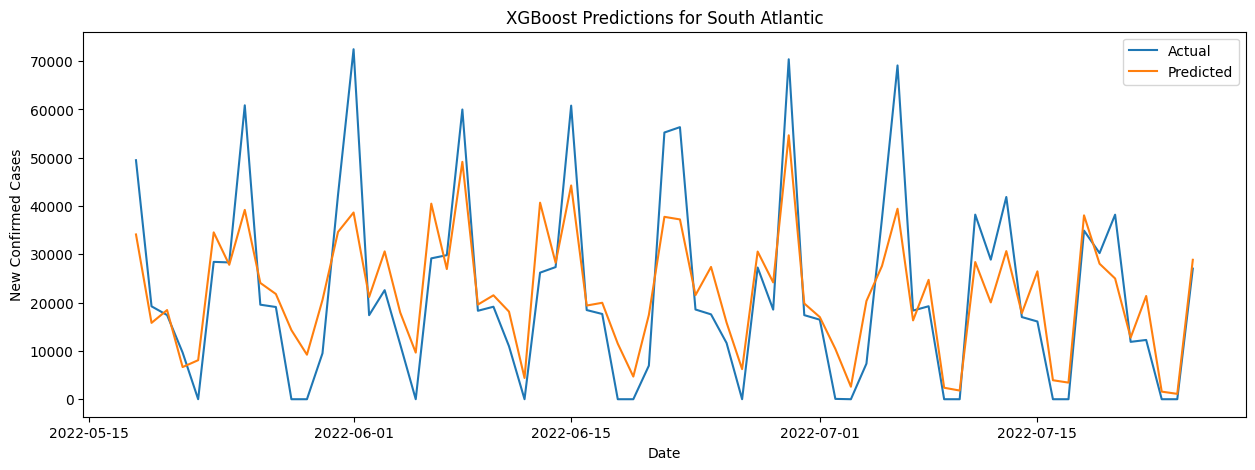



Training model for West North Central...
MAE: 459.56
RMSE: 1106.21
MASE: 0.43


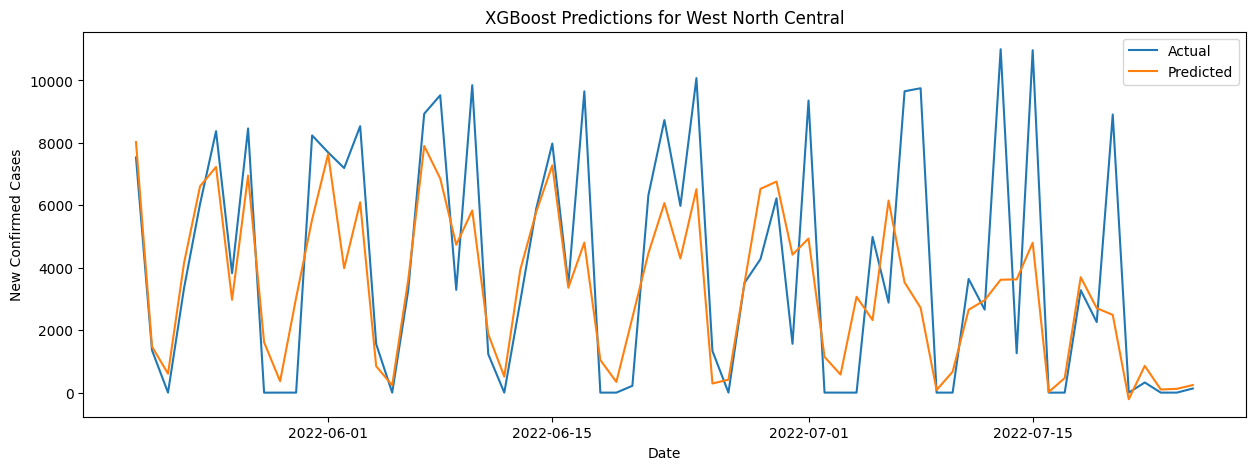



Training model for West South Central...
MAE: 982.74
RMSE: 1813.94
MASE: 0.25


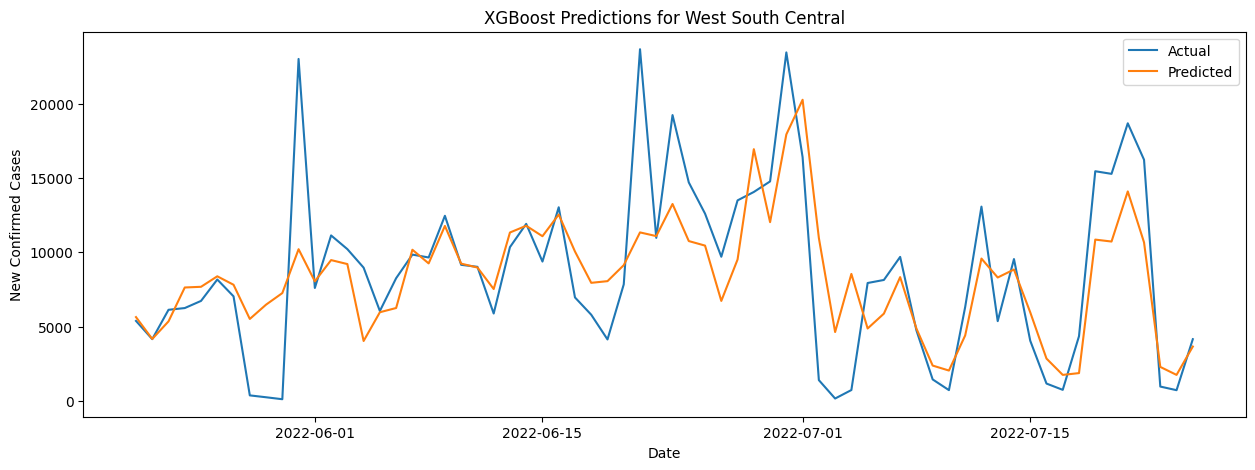



--- 17.28 seconds ---


In [90]:
start_time = time.time()
for df in datasets:
    train_baseline_model(df, plot=True)
    print("\n")
    
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

## Feature Selection

In [92]:
def feature_selection(df, feature_perc=0.95):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    df.sort_index(inplace=True)

    unique_days = df.index.normalize().unique()

    train_days = unique_days[:int(len(unique_days) * 0.85)]
    validation_days = unique_days[int(len(unique_days) * 0.85):int(len(unique_days) * 0.925)]
    test_days = unique_days[int(len(unique_days) * 0.925):]


    train_df = df[df.index.normalize().isin(train_days)]
    validation_df = df[df.index.normalize().isin(validation_days)]
    # test_df = df[df.index.normalize().isin(test_days)]

    # train_df, temp_test_df = train_test_split(df, test_size=0.15, shuffle=False)
    # val, test  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    train = train_df
    test = validation_df

    X_train = train.drop(columns=['new_confirmed', 'region', 'location_key'])
    # X_train = train[features]
    y_train = train['new_confirmed']
    # y_train_log = np.log(y_train)
    # y_train_log.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    X_test = test.drop(columns=['new_confirmed', 'region', 'location_key'])
    # X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, early_stopping_rounds=10,)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)
     

    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
    stats = stats.sort_values('importance', ascending=False)  
    stats = stats.sort_values('importance', ascending=False)
    stats["cum_importance"] = np.cumsum(stats['importance'])

    n_percent = np.where(stats["cum_importance"] > feature_perc)[0][0] + 1

    important_features = stats[:n_percent] 
    print(f"Number of features for {feature_perc * 100}% importance: {n_percent}, out of {len(stats)}")
    return region, list(important_features.index)

In [93]:
first_fs = {}
for df in datasets:
    region, features = feature_selection(df)
    first_fs[region] = features
    print("\n")


Training model for East North Central...
Number of features for 95.0% importance: 31, out of 62


Training model for East South Central...
Number of features for 95.0% importance: 36, out of 62


Training model for Mid-Atlantic...
Number of features for 95.0% importance: 26, out of 61


Training model for Mountain...
Number of features for 95.0% importance: 36, out of 65


Training model for New England...
Number of features for 95.0% importance: 26, out of 62


Training model for Pacific...
Number of features for 95.0% importance: 16, out of 63


Training model for South Atlantic...
Number of features for 95.0% importance: 31, out of 66


Training model for West North Central...
Number of features for 95.0% importance: 35, out of 64


Training model for West South Central...
Number of features for 95.0% importance: 21, out of 60




In [94]:
first_fs

{'East North Central': ['7_day_shift',
  'stringency_index',
  '7_day_avg',
  'dayofyear',
  'new_deceased',
  'average_temperature_celsius',
  'year',
  '2_day_shift',
  'cumulative_persons_vaccinated',
  'cumulative_persons_fully_vaccinated_pfizer',
  '1_day_shift',
  'new_persons_fully_vaccinated_janssen',
  'school_closing',
  'cumulative_persons_fully_vaccinated',
  'new_persons_fully_vaccinated_pfizer',
  'cumulative_persons_fully_vaccinated_moderna',
  'international_travel_controls',
  'relative_humidity',
  'new_hospitalized_patients',
  'location_key_US_OH',
  'income_support',
  'cumulative_confirmed',
  'cumulative_hospitalized_patients',
  'cumulative_deceased',
  'day',
  'location_key_US_MI',
  'weekofyear',
  'new_persons_vaccinated',
  'rainfall_mm',
  'new_vaccine_doses_administered_moderna',
  'maximum_temperature_celsius'],
 'East South Central': ['7_day_shift',
  '7_day_avg',
  '1_day_shift',
  'new_deceased',
  '2_day_shift',
  'day',
  'location_key_US_AL',
  'st

In [96]:
def train_model_with_features(df, features, feature_perc=0.95, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    # size = round(df.shape[0]*0.15)
    if 'date' in df.columns:
        df.set_index('date', inplace=True)

    unique_days = df.index.normalize().unique()

    train_days = unique_days[:int(len(unique_days) * 0.85)]
    validation_days = unique_days[int(len(unique_days) * 0.85):int(len(unique_days) * 0.925)]
    test_days = unique_days[int(len(unique_days) * 0.925):]


    train_df = df[df.index.normalize().isin(train_days)]
    validation_df = df[df.index.normalize().isin(validation_days)]
    train = train_df
    test = validation_df

    X_train = train[features]
    y_train = train['new_confirmed']

    X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)
    

    # make predictions
    y_pred = model.predict(X_test)

    actual = y_test.groupby(y_test.index).sum()
    y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
    y_train_gb = y_train.groupby(y_train.index).sum()

    # calculate metrics
    mae = mean_absolute_error(actual, y_pred_gb)
    mse = mean_squared_error(actual, y_pred_gb)
    rmse = mean_squared_error(actual, y_pred_gb, squared=False)
    mase = mean_absolute_scaled_error(actual, y_pred_gb, y_train=y_train_gb)

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions for {region} on Validation Set')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(actual.index, actual, label='Actual')
        plt.plot(actual.index, y_pred_gb, label='Predicted')
        plt.legend() 
        plt.show()

    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
    stats = stats.sort_values('importance', ascending=False)  
    stats = stats.sort_values('importance', ascending=False)
    stats["cum_importance"] = np.cumsum(stats['importance'])

    n_percent = np.where(stats["cum_importance"] > feature_perc)[0][0] + 1

    important_features = stats[:n_percent] 
    print(f"Number of features for {feature_perc * 100}% importance: {n_percent}, out of {len(stats)}")
    print(f"Important features: {list(important_features.index)}")


In [99]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    features = first_fs[region]
    train_model_with_features(df, features, plot=False)
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
MAE: 3604.84
MSE: 29918215.63
RMSE: 5469.75
MASE: 0.42
Number of features for 95.0% importance: 22, out of 31
Important features: ['7_day_shift', 'new_deceased', 'dayofyear', '7_day_avg', '2_day_shift', 'average_temperature_celsius', '1_day_shift', 'stringency_index', 'international_travel_controls', 'cumulative_persons_fully_vaccinated', 'cumulative_persons_vaccinated', 'new_hospitalized_patients', 'cumulative_persons_fully_vaccinated_pfizer', 'new_persons_fully_vaccinated_janssen', 'location_key_US_OH', 'relative_humidity', 'cumulative_hospitalized_patients', 'income_support', 'cumulative_confirmed', 'cumulative_deceased', 'new_persons_fully_vaccinated_pfizer', 'weekofyear']


Training model for East South Central...
MAE: 739.45
MSE: 1118268.91
RMSE: 1057.48
MASE: 0.21
Number of features for 95.0% importance: 27, out of 36
Important features: ['7_day_avg', '7_day_shift', '1_day_shift', 'new_deceased', 'month', 'location_key_US_AL', '2_day_shif

## Parameter Tuning

In [102]:
def parameter_tune(df, features=None,):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.2)
    if 'date' in df.columns:
        df.set_index('date', inplace=True)
    
    unique_days = df.index.normalize().unique()

    train_days = unique_days[:int(len(unique_days) * 0.85)]
    validation_days = unique_days[int(len(unique_days) * 0.85):int(len(unique_days) * 0.925)]
    # test_days = unique_days[int(len(unique_days) * 0.925):]


    train_df = df[df.index.normalize().isin(train_days)]
    validation_df = df[df.index.normalize().isin(validation_days)]
    # test_df = df[df.index.normalize().isin(test_days)]
    
    train = train_df
    test = validation_df

    X_train = train[features]
    y_train = train['new_confirmed']

    X_test = test[features]
    y_test = test['new_confirmed']

    if features:
        X_train = train[features]
        X_test = test[features]
    else:
        X_train = train.drop(columns=['new_confirmed', 'region', 'location_key'])
        X_test = test.drop(columns=['new_confirmed', 'region', 'location_key'])
    
    y_train = train['new_confirmed']
    y_test = test['new_confirmed']

    # fit model
    results_df = pd.DataFrame(columns=['Learning Rate', 'N Estimators', 'Depth', 'MAE', 'RMSE', 'MASE'])
    max_depths =  [2, 3, 5, 8, None]
    # learning_rates = [0.01, 0.05, 0.1, 0.15]
    learning_rates = [0.05, 0.1, 0.25, 0.5]
    # n_estimators = [250, 500, 1000]
    n_estimators = [25, 50, 100, 250, 500]
    # subsample = [0.7, 0.8, 0.9]
    for lr in learning_rates:
        for n_est in n_estimators:
            for depth in max_depths:
                if depth == None:
                    model = xgb.XGBRegressor(n_estimators=n_est, learning_rate=lr, early_stopping_rounds=10, n_jobs=-1)
                else:
                    model = xgb.XGBRegressor(n_estimators=n_est, learning_rate=lr, max_depth=depth, early_stopping_rounds=10, n_jobs=-1)
                
                model.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)], 
                        verbose=False)
                

                # make predictions
                y_pred = model.predict(X_test)

                actual = y_test.groupby(y_test.index).sum()
                y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
                y_train_gb = y_train.groupby(y_train.index).sum()

                # calculate metrics
                mae = mean_absolute_error(y_test, y_pred)
                # mse = mean_squared_error(actual, y_pred_gb)
                rmse = mean_squared_error(y_test, y_pred, squared=False)
                mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

                results_df = results_df.append({'Learning Rate': lr, 'N Estimators': n_est, 'Depth': depth,
                                            'MAE': mae, 'RMSE': rmse, 'MASE': mase}, 
                                        ignore_index=True)
    results_df = results_df.sort_values('MASE')
    print(results_df.head(1))
    return region, {"learning_rate": results_df['Learning Rate'].iloc[0],
                    "n_estimators": results_df['N Estimators'].iloc[0],
                    "max_depth": results_df['Depth'].iloc[0]}

In [103]:
start_time = time.time()
params = {}
for df in datasets:
    region = df["region"].iloc[0]
    # features = baseline_fs[region]["features"]
    region, best = parameter_tune(df, features=first_fs[region])
    params[region] = best
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")
params

Training model for East North Central...
    Learning Rate  N Estimators  Depth         MAE         RMSE      MASE
18           0.05         250.0    8.0  783.419178  2128.557457  0.332321


Training model for East South Central...
    Learning Rate  N Estimators  Depth         MAE        RMSE      MASE
21           0.05         500.0    3.0  209.097793  366.323217  0.138754


Training model for Mid-Atlantic...
    Learning Rate  N Estimators  Depth         MAE         RMSE      MASE
53           0.25          25.0    8.0  924.259644  1793.438644  0.339196


Training model for Mountain...
    Learning Rate  N Estimators  Depth         MAE         RMSE      MASE
98            0.5         500.0    8.0  222.963722  1008.433601  0.205019


Training model for New England...
    Learning Rate  N Estimators  Depth         MAE        RMSE      MASE
22           0.05         500.0    5.0  222.882016  542.460903  0.224712


Training model for Pacific...
    Learning Rate  N Estimators  Depth    

{'East North Central': {'learning_rate': 0.05,
  'n_estimators': 250.0,
  'max_depth': 8.0},
 'East South Central': {'learning_rate': 0.05,
  'n_estimators': 500.0,
  'max_depth': 3.0},
 'Mid-Atlantic': {'learning_rate': 0.25,
  'n_estimators': 25.0,
  'max_depth': 8.0},
 'Mountain': {'learning_rate': 0.5, 'n_estimators': 500.0, 'max_depth': 8.0},
 'New England': {'learning_rate': 0.05,
  'n_estimators': 500.0,
  'max_depth': 5.0},
 'Pacific': {'learning_rate': 0.5, 'n_estimators': 500.0, 'max_depth': nan},
 'South Atlantic': {'learning_rate': 0.25,
  'n_estimators': 500.0,
  'max_depth': 3.0},
 'West North Central': {'learning_rate': 0.05,
  'n_estimators': 500.0,
  'max_depth': 8.0},
 'West South Central': {'learning_rate': 0.5,
  'n_estimators': 500.0,
  'max_depth': 5.0}}

# Final Model

In [114]:
params={'East North Central': {'learning_rate': 0.05,
  'n_estimators': 250.0,
  'max_depth': 8.0},
 'East South Central': {'learning_rate': 0.05,
  'n_estimators': 500.0,
  'max_depth': 3.0},
 'Mid-Atlantic': {'learning_rate': 0.25,
  'n_estimators': 25.0,
  'max_depth': 8.0},
 'Mountain': {'learning_rate': 0.5, 'n_estimators': 500.0, 'max_depth': 8.0},
 'New England': {'learning_rate': 0.05,
  'n_estimators': 500.0,
  'max_depth': 5.0},
 'Pacific': {'learning_rate': 0.5, 'n_estimators': 500.0, 'max_depth': None},
 'South Atlantic': {'learning_rate': 0.25,
  'n_estimators': 500.0,
  'max_depth': 3.0},
 'West North Central': {'learning_rate': 0.05,
  'n_estimators': 500.0,
  'max_depth': 8.0},
 'West South Central': {'learning_rate': 0.5,
  'n_estimators': 500.0,
  'max_depth': 5.0}}

In [119]:
def final_model(df, params, features, plot=False,):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    # features = params["features"]
    if features is None:
        features = df.drop(columns=['new_confirmed', 'region', 'location_key']).columns
    n_estimators = int(params["n_estimators"])
    learning_rate = params["learning_rate"]
    depth = int(params["max_depth"]) if params["max_depth"] else None

    unique_days = df.index.normalize().unique()

    train_days = unique_days[:int(len(unique_days) * 0.85)]
    validation_days = unique_days[int(len(unique_days) * 0.85):int(len(unique_days) * 0.925)]
    test_days = unique_days[int(len(unique_days) * 0.925):]


    train_df = df[df.index.normalize().isin(train_days)]
    validation_df = df[df.index.normalize().isin(validation_days)]
    test_df = df[df.index.normalize().isin(test_days)]

    train = pd.concat([train_df, validation_df])
    test = test_df


    X_train = train[features]
    y_train = train['new_confirmed']

    X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    if depth == None:
        model = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, early_stopping_rounds=10)
    else:
        model = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=depth, early_stopping_rounds=10)

    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)
    print(f"Model Params: n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={depth}, early_stopping_rounds=10")
    

    # make predictions
    y_pred = model.predict(X_test)

    actual = y_test.groupby(y_test.index).sum()
    y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
    y_train_gb = y_train.groupby(y_train.index).sum()

    # calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    # mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

    print(f'MAE: {round(mae, 2)}')
    # print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions for {region} on {"Test"} Set')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(actual.index, actual, label='Actual')
        plt.plot(actual.index, y_pred_gb, label='Predicted')
        plt.legend() 
        plt.show()

    return region, mase, rmse, mae
        

Training model for East North Central...
Model Params: n_estimators=250, learning_rate=0.05, max_depth=8, early_stopping_rounds=10
MAE: 859.87
RMSE: 1685.34
MASE: 0.37


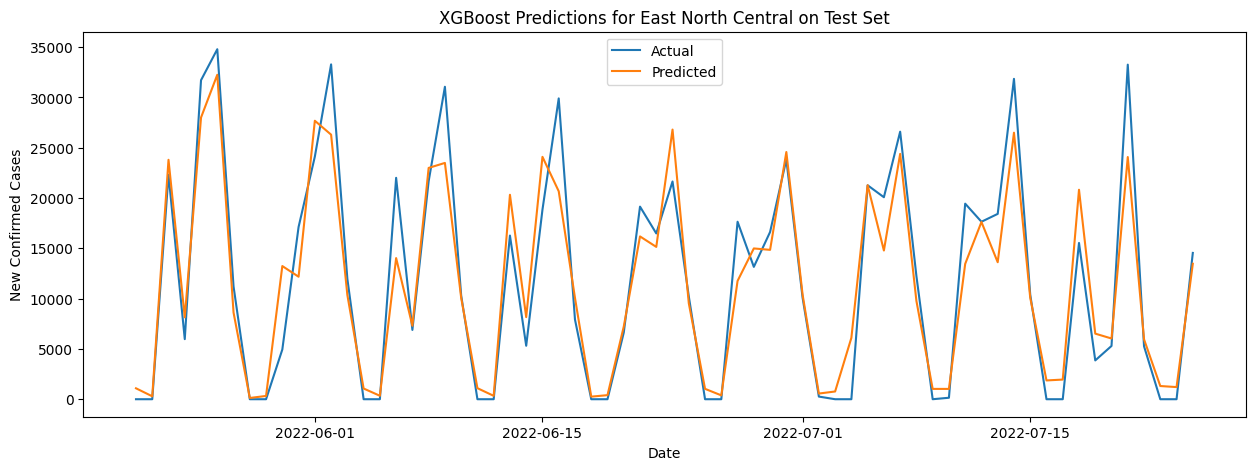


Training model for East South Central...
Model Params: n_estimators=500, learning_rate=0.05, max_depth=3, early_stopping_rounds=10
MAE: 738.52
RMSE: 1355.09
MASE: 0.52


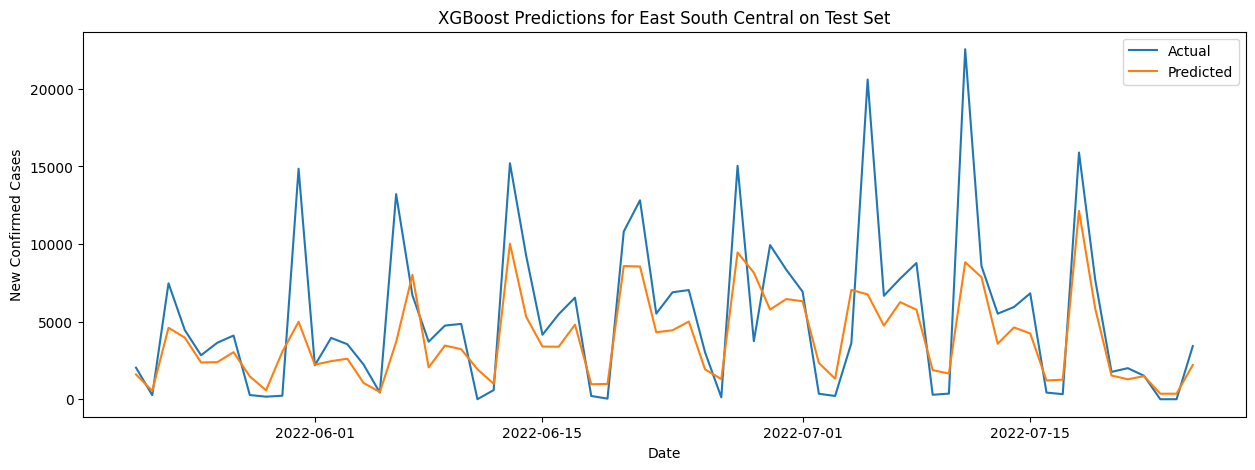


Training model for Mid-Atlantic...
Model Params: n_estimators=25, learning_rate=0.25, max_depth=8, early_stopping_rounds=10
MAE: 2554.05
RMSE: 3741.74
MASE: 0.94


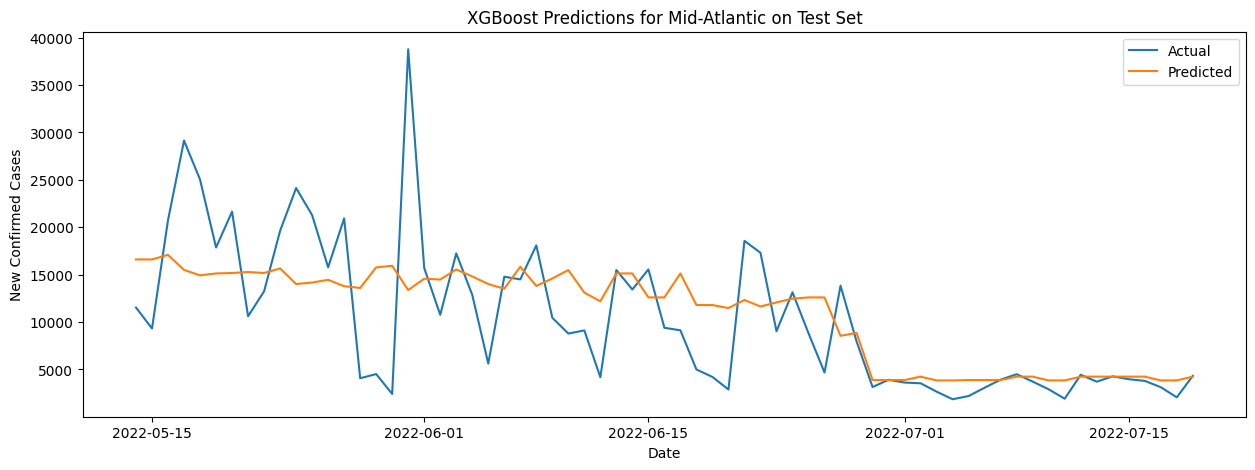


Training model for Mountain...
Model Params: n_estimators=500, learning_rate=0.5, max_depth=8, early_stopping_rounds=10
MAE: 543.89
RMSE: 1454.98
MASE: 0.52


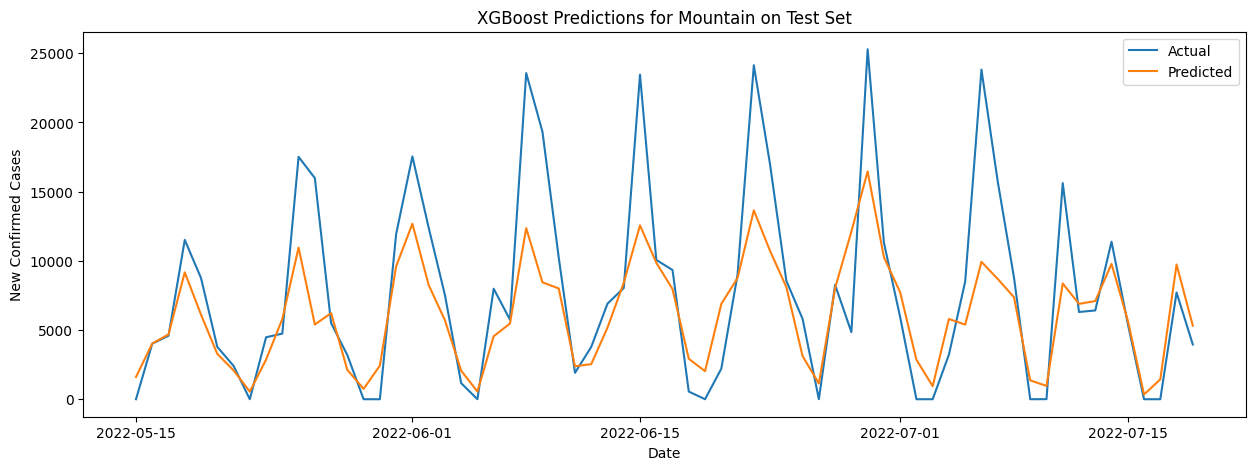


Training model for New England...
Model Params: n_estimators=500, learning_rate=0.05, max_depth=5, early_stopping_rounds=10
MAE: 386.23
RMSE: 660.19
MASE: 0.39


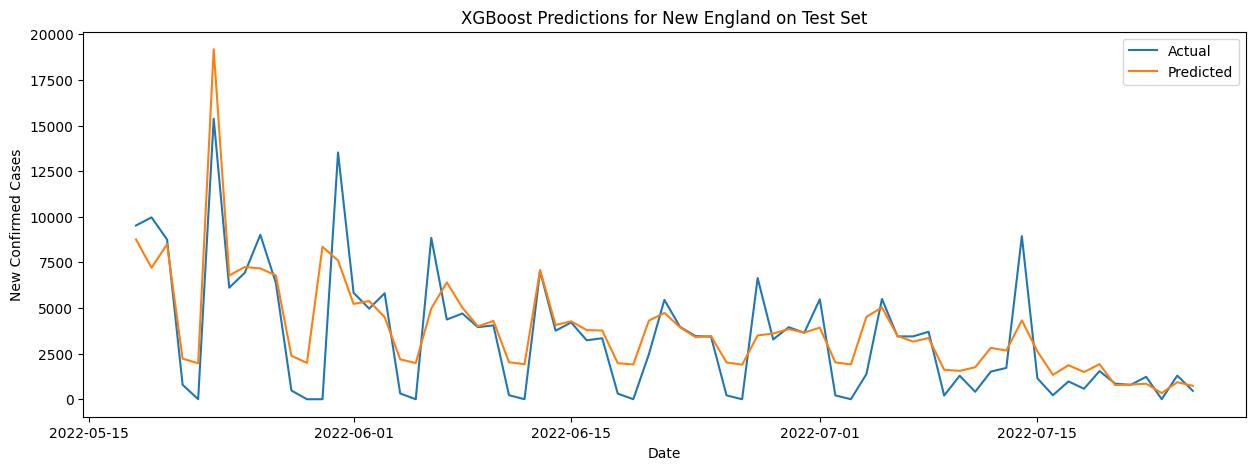


Training model for Pacific...
Model Params: n_estimators=500, learning_rate=0.5, max_depth=None, early_stopping_rounds=10
MAE: 3032.02
RMSE: 7215.89
MASE: 0.64


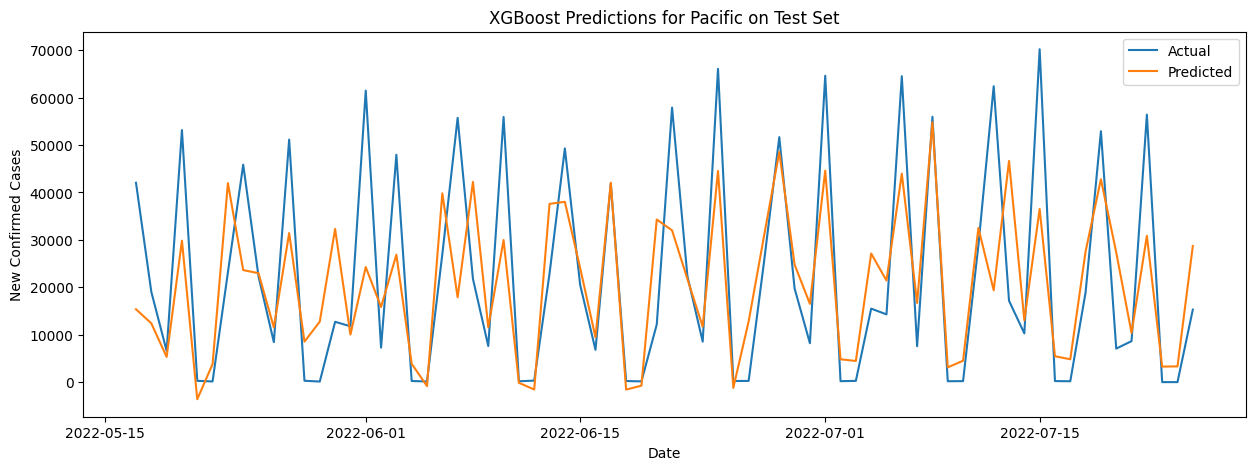


Training model for South Atlantic...
Model Params: n_estimators=500, learning_rate=0.25, max_depth=3, early_stopping_rounds=10
MAE: 1437.03
RMSE: 3382.55
MASE: 0.51


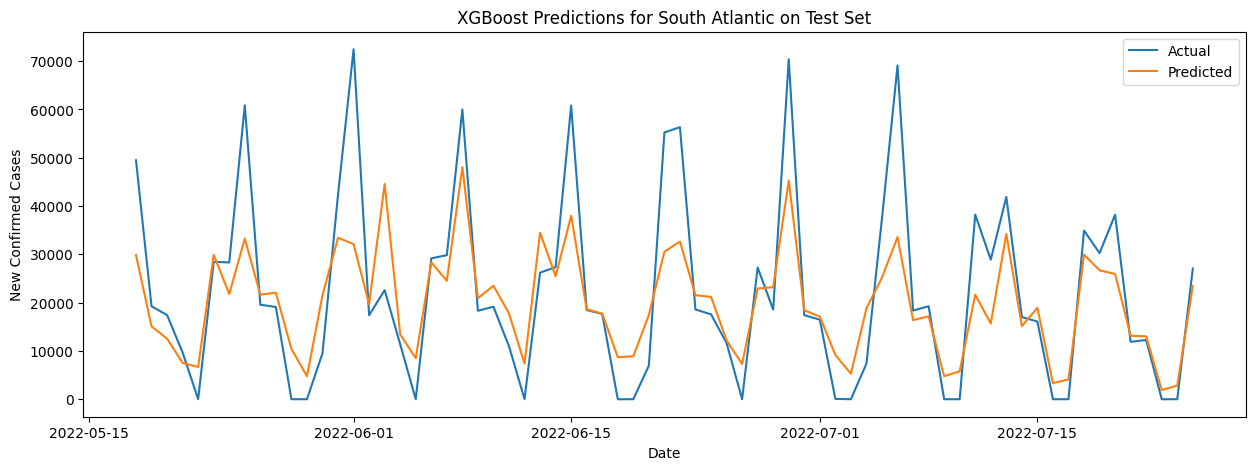


Training model for West North Central...
Model Params: n_estimators=500, learning_rate=0.05, max_depth=8, early_stopping_rounds=10
MAE: 480.81
RMSE: 1137.06
MASE: 0.45


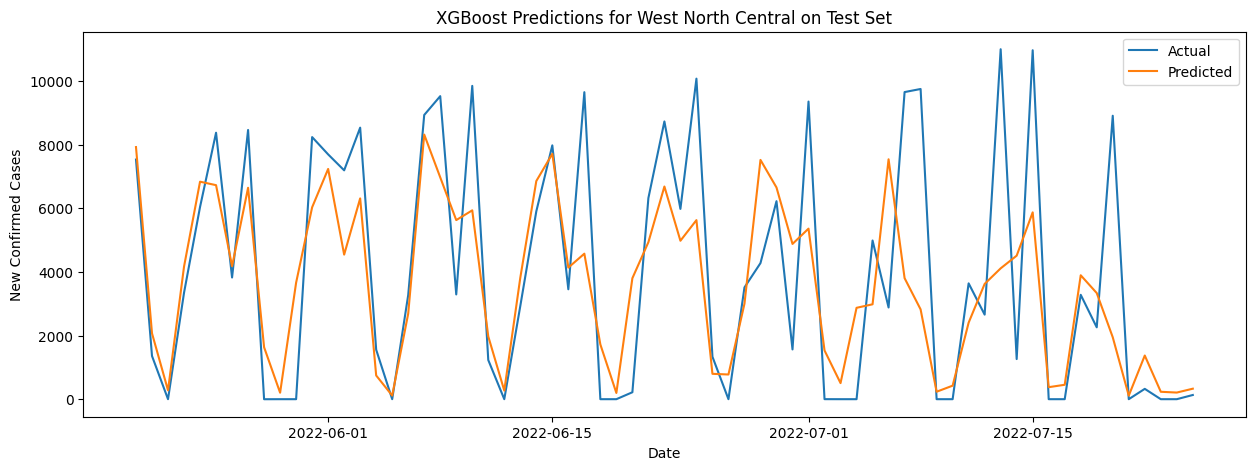


Training model for West South Central...
Model Params: n_estimators=500, learning_rate=0.5, max_depth=5, early_stopping_rounds=10
MAE: 914.25
RMSE: 1749.08
MASE: 0.23


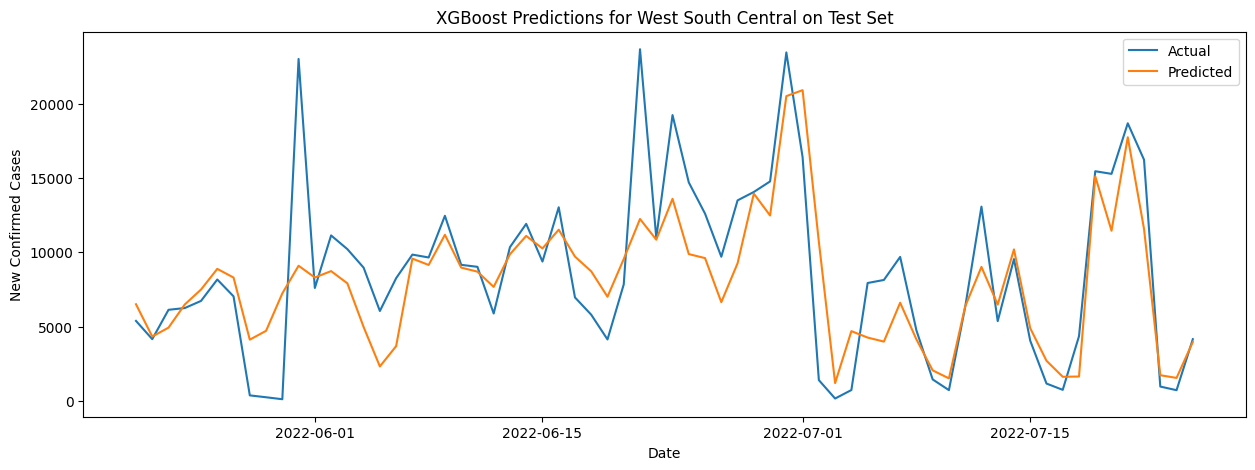


--- 8.94 seconds ---


,Region,MASE,RMSE,MAE
0,East North Central,0.366366,1685.342394,859.869446
1,East South Central,0.518439,1355.085515,738.524300
2,Mid-Atlantic,0.936492,3741.736376,2554.051072
3,Mountain,0.515972,1454.980530,543.890891
4,New England,0.394952,660.192737,386.227870
5,Pacific,0.637601,7215.888359,3032.017248
6,South Atlantic,0.514687,3382.545397,1437.031953
7,West North Central,0.451762,1137.063613,480.810509
8,West South Central,0.230390,1749.079844,914.249957


In [120]:
start_time = time.time()
results = []
for df in datasets:
    region = df["region"].iloc[0]
    params_tmp = params[region]
    region, mase, rmse, mae = final_model(df, params_tmp, features=first_fs[region], plot=True)
    results.append((region, mase, rmse, mae))
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

results = pd.DataFrame(results, columns=["Region", "MASE", "RMSE", "MAE"])
results